In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/Hyperparam.csv", sep=',')

In [2]:
df[["cl", "nl", "nc", "ep"]] = pd.DataFrame(df['param'].str.translate({ord(letter): None for letter in 'clnep'}).str.split(",").tolist(),columns=["cl", "nl", "nc", "ep"]).astype(int)
df

,Unnamed: 0,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,...,wQuantileLoss[0.975],mean_absolute_QuantileLoss,mean_wQuantileLoss,MAE_Coverage,OWA,param,cl,nl,nc,ep
0,8,LK Amberg-Sulzbach {1},2018-01-22/2018-01-28,472.471247,692.0,1637.0,16.876289,1.834975,3.887802,0.594399,...,NaN,NaN,NaN,NaN,NaN,"cl 4, nl 2, nc 64, ep 2",4,2,64,2
1,0,aggregated {1},NaN,642.261721,242966.0,528476.0,13.288308,1.452949,4.251429,0.784638,...,0.214962,154380.471429,0.292124,0.225892,NaN,"cl 4, nl 2, nc 64, ep 2",4,2,64,2
2,8,LK Amberg-Sulzbach {2},2018-01-22/2018-01-28,744.480348,906.0,1637.0,16.876289,1.834975,5.090099,0.744457,...,NaN,NaN,NaN,NaN,NaN,"cl 4, nl 2, nc 64, ep 2",4,2,64,2
3,0,aggregated {2},NaN,1042.687434,307999.0,528476.0,13.288308,1.452949,5.271021,0.920729,...,0.377716,207788.642857,0.393185,0.225317,NaN,"cl 4, nl 2, nc 64, ep 2",4,2,64,2
4,8,LK Amberg-Sulzbach {3},2018-01-22/2018-01-28,1005.730751,1148.0,1637.0,16.876289,1.834975,6.449706,0.990861,...,NaN,NaN,NaN,NaN,NaN,"cl 4, nl 2, nc 64, ep 2",4,2,64,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,0,aggregated {2},NaN,1065.405855,302959.0,528476.0,13.288308,1.452949,5.286231,0.788170,...,0.399995,215172.742857,0.407157,0.249718,NaN,"cl 104, nl 8, nc 256, ep 8",104,8,256,8
644,8,LK Amberg-Sulzbach {3},2018-01-22/2018-01-28,994.704011,960.0,1637.0,16.876289,1.834975,5.393482,0.796855,...,NaN,NaN,NaN,NaN,NaN,"cl 104, nl 8, nc 256, ep 8",104,8,256,8
645,0,aggregated {3},NaN,1308.761001,334210.0,528476.0,13.288308,1.452949,5.751298,0.832956,...,0.502941,244236.864286,0.462153,0.251482,NaN,"cl 104, nl 8, nc 256, ep 8",104,8,256,8
646,8,LK Amberg-Sulzbach {4},2018-01-22/2018-01-28,1074.616060,1053.0,1637.0,16.876289,1.834975,5.915976,0.920740,...,NaN,NaN,NaN,NaN,NaN,"cl 104, nl 8, nc 256, ep 8",104,8,256,8


In [3]:
df05 = df.loc[df.item_id.isin(["aggregated {4}"]),:].copy()
print(df05.sort_values(by=['QuantileLoss[0.5]'])[['QuantileLoss[0.5]', 'item_id', 'param']])

     QuantileLoss[0.5]         item_id                       param
383           347209.0  aggregated {4}    cl 52, nl 8, nc 64, ep 8
495           348051.0  aggregated {4}  cl 104, nl 2, nc 256, ep 4
287           348443.0  aggregated {4}   cl 52, nl 2, nc 256, ep 8
271           349035.0  aggregated {4}   cl 52, nl 2, nc 256, ep 2
551           349595.0  aggregated {4}  cl 104, nl 4, nc 128, ep 8
..                 ...             ...                         ...
71            385446.0  aggregated {4}    cl 4, nl 2, nc 256, ep 8
47            398134.0  aggregated {4}    cl 4, nl 2, nc 128, ep 8
15            408407.0  aggregated {4}     cl 4, nl 2, nc 64, ep 4
23            412087.0  aggregated {4}     cl 4, nl 2, nc 64, ep 8
7             413236.0  aggregated {4}     cl 4, nl 2, nc 64, ep 2

[81 rows x 3 columns]


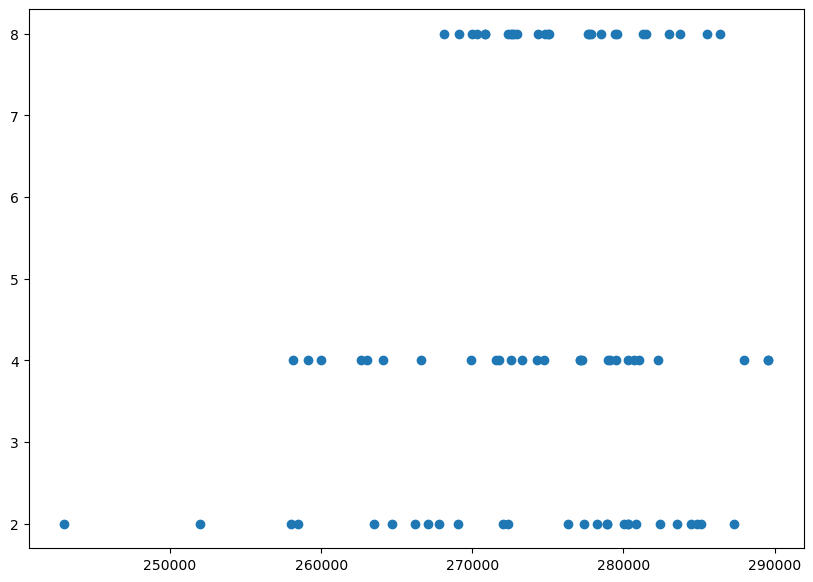

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.scatter(df.loc[df.item_id.isin(["aggregated {1}"]),"QuantileLoss[0.5]"],df.loc[df.item_id.isin(["aggregated {1}"]),"nl"])